# Notebook to QC Section 2.3 that relates advective fluxes through the lateral boundaries of control volume. Due to numerical mixing, I do not expect these terms to close with a very small residual like in "QC_diffusion". 
See the appendix of Broatch and MacCready (2022) JPO for more information

In [9]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from xhistogram.xarray import histogram
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
from datetime import datetime

In [2]:
#Open model output
path = glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds = xroms.open_mfnetcdf(path)
ds, grid = xroms.roms_dataset(ds)

#Indexing for nested grid
xislice = slice(271,404)
etaslice = slice(31,149)

In [4]:
def volume_flux(ds, grid, xislice, etaslice):
    '''
Computes the volume advection through the lateral boundaries of a control volume for ROMS model output using
average files. We use the volume-conserving fluxes Huon and Hvom to increase the numerical accuracy. 
-----
Input: 
ds - xarray roms dataset
grid - xgcm grid of roms output
xislice - slice object of desired xi points
etaslice -slice object of desired eta points
-----
Output:
Qds: Xarray dataset of volume flux at the four horizontal control surfaces
vol_adv: Xarray dataarray of the net volume flux as a function of time only
    '''
    uflux = ds.Huon.isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    vflux = ds.Hvom.isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    QW = uflux.isel(xi_u = 0) #West
    QE = uflux.isel(xi_u = -1) #East
    QN = vflux.isel(eta_v = -1) #North
    QS = vflux.isel(eta_v = 0) #South

    #Name individual components in case histograms are made, which require the variables be named
    QW.name = 'QW'
    QE.name = 'QE'
    QN.name = 'QN'
    QS.name = 'QS'

    Qds = xr.merge([QW, QE, QN, QS], compat='override')
     
    return Qds

Qds = volume_flux(ds, grid, xislice, etaslice) 
# Volume advection - negative sign is to make fluxes out of the volume positive
voladv_xr = -(Qds.QW.sum(['eta_rho', 's_rho'])-Qds.QE.sum(['eta_rho', 's_rho']) \
             +Qds.QS.sum(['xi_rho', 's_rho'])-Qds.QN.sum(['xi_rho', 's_rho']))
voladv_xr.attrs = ''

#Change order of divergence, remove the negative sign. Check this for appendix.
#Should be equal to vol_adv_xr
voladv_xr1 = (Qds.QE.sum(['eta_rho', 's_rho'])-Qds.QW.sum(['eta_rho', 's_rho']) \
             +Qds.QN.sum(['xi_rho', 's_rho'])-Qds.QS.sum(['xi_rho', 's_rho']))
voladv_xr1.attrs = ''

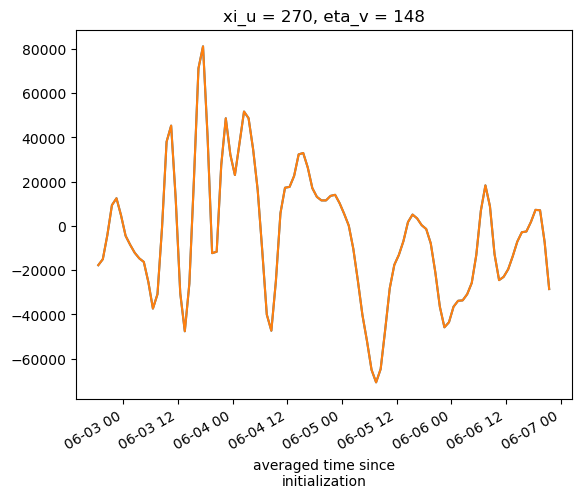

In [6]:
voladv_xr[:100].plot()
voladv_xr1[:100].plot()

In [7]:
print(voladv_xr[:100].values-voladv_xr1[:100].values)

[ 0.00390625 -0.00195312 -0.00585938  0.          0.          0.00390625
  0.          0.          0.          0.          0.          0.
  0.00390625 -0.00390625  0.00195312  0.          0.00390625  0.
  0.          0.          0.00195312  0.          0.          0.
  0.00390625 -0.00097656  0.         -0.00390625  0.00390625 -0.00195312
 -0.00195312  0.          0.          0.00390625  0.          0.00097656
 -0.00097656  0.          0.          0.          0.00195312 -0.00390625
 -0.0078125  -0.00195312  0.0078125   0.          0.0078125   0.00390625
 -0.0078125   0.          0.          0.          0.015625    0.0078125
  0.          0.01171875 -0.01171875 -0.00585938  0.         -0.00390625
  0.00390625 -0.0078125   0.01171875 -0.0078125  -0.0078125  -0.00195312
  0.00390625 -0.01171875 -0.01367188  0.015625    0.0078125   0.0078125
  0.015625    0.         -0.0078125   0.          0.0078125   0.
 -0.0078125  -0.00390625  0.00390625  0.00390625  0.          0.
  0.          0.    

# This small residual is because we did not declare double precision, many orders of magnitude smaller than the actual advection. The sign convection is described in the appendix is correct. 

# Next - check that the residual of the extra $s^2$ advection terms 

In [11]:
#Advection
s2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltsquareadv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltvaradv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbarsprime_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/2sbarsprime_advection_ver1_2010_*.nc')['2sbarprime_advection'].sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbar2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/sbar2_advection_ver1_2010_*.nc').sbar2_advection.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
time = s2_advection.ocean_time.values

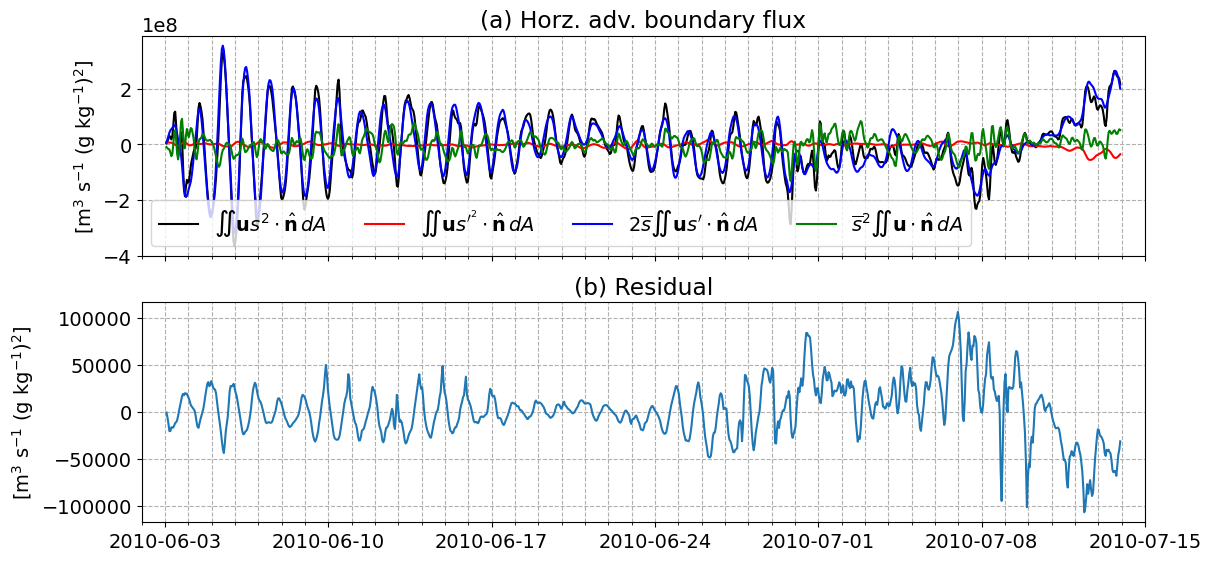

In [16]:
plt.rcParams.update({'font.size': 14})

myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

fig, ax = plt.subplots(2,1, figsize = (12,2.75*2), constrained_layout = True, sharey = False)

ax[0].plot(time, s2_advection, lw = 1.5, c = 'k', label = r'$\iint \mathbf{u}s^2 \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(time, sprime2_advection, lw = 1.5, c = 'r', label = r'$\iint \mathbf{u}s^{\prime^2} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(time, sbarsprime_advection, lw = 1.5, c = 'b', label = r'$2 \overline{s} \iint \mathbf{u}s^{\prime} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].plot(time, sbar2_advection, lw = 1.5, c = 'g', label = r'$\overline{s}^2 \iint \mathbf{u} \cdot \hat{\mathbf{n}} \, dA$')
ax[0].set_title('(a) Horz. adv. boundary flux')
ax[0].legend(loc = 'lower left', ncol = 4)
ax[0].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_xticks(ticks = dates)
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

ax[1].plot(time, s2_advection-(sprime2_advection+sbarsprime_advection+sbar2_advection), lw = 1.5)
ax[1].set_title('(b) Residual')
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('Time [hrs]')
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[1].set_xticks(ticks = dates)
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('')
ax[1].set_xticklabels([])
ax[1].xaxis.set_major_formatter(myFmt)

for i in range(2):
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
    
# plt.savefig('QC_advection.jpg', dpi = 300, bbox_inches='tight')

# There is a sizeable residual here due to numerical mixing, but it is still several orders of magnitude smaller than the terms themselves. This is satisfactory. 